In [106]:
import pandas as pd
from geopy import Point
import numpy as np
from geopy import distance
from numba import njit
from scipy.optimize import optimize
from skopt import gp_minimize
import skopt.plots as skplt
import matplotlib.pyplot as plt


In [107]:

data = pd.read_csv('2013_Events.csv')
data['Event start date'] = pd.to_datetime(data['Event start date'])
data = data.sort_values(by = 'Event start date')
data = data.loc[data['Event start date'] > '2013-11-15']

In [7]:
print(data.loc[data['Oblast'] == 'Ukraine'].shape[0])
print(data.loc[data['Oblast'] == 'Ukraine']['Location'])

26
5897                                          Web
5898                                          Web
5903                                          Web
5899                                          Web
5900    Donetsk-Kharkiv highway, Boryspil highway
5901    Donetsk-Kharkiv highway, Boryspil highway
5902                                          Web
5904                                          Web
5905                                          Web
5906                                          Web
5908                                          Web
5907                                          Web
5909                                      Ukraine
5910                                          Web
5911                                          Web
5912                                          Web
5913                                          Web
5915                                          Web
5914                                          Web
5916                                          W

In [8]:
data = data.loc[data['Oblast'] != 'Ukraine']
data['Number of events'] = 0
data = data.groupby(['Event start date', 'Oblast'], as_index=False).aggregate({'Number of events': 'size', 'Number of protesters': 'sum'})

data['Event start date'] = pd.to_numeric(data['Event start date'])
data['Event start date'] = ((data['Event start date']-1384560000000000000)/86400000000000).astype(int)

In [9]:
# Weighted centroid by population?

oblast_coords = {'Cherkasy':Point(49.4444, 32.0598), 'Chernihiv':Point(51.4982, 31.2893), 'Chernivtsi':Point(48.2917, 25.9352),
                 'Crimea':Point(45.3453, 34.4997), 'Dnipropetrovsk':Point(48.4647, 35.0462),
                 'Donetsk':Point(48.0159, 37.8028), 'Ivano-Frankivsk':Point(48.9226, 24.7111),
                 'Kharkiv':Point(49.9935, 36.2304), 'Kherson':Point(46.6354, 32.6169),
                 'Khmelnytskyi':Point(49.4230, 26.9871), 'Kirovohrad':Point(48.5079, 32.2623),
                 'Kyiv':Point(50.0530, 30.7667), 'Luhansk':Point(48.5740, 39.3078),
                 'Lutsk':Point(50.7472, 25.3254), 'Lviv':Point(49.8397, 24.0297),
                 'Mykolaiv':Point(46.9750, 31.9946), 'Odesa':Point(46.4846, 30.7326),
                 'Poltava':Point(49.5883, 34.5514), 'Rivne':Point(50.6199, 26.2516),
                 'Sumy':Point(50.9077, 34.7981), 'Ternopil':Point(49.5535, 25.5948),
                 'Uzhhorod':Point(48.6208, 22.2879), 'Vinnytsia':Point(49.2331, 28.4682),
                 'Zaporizhzhia':Point(47.8388, 35.1396), 'Zhytomyr':Point(50.2547, 28.6587)}

In [10]:
data.tail()
# 46 days, 25 oblasts, 756 entries

,Event start date,Oblast,Number of events,Number of protesters
751,45,Donetsk,6,46.0
752,45,Kharkiv,2,58.0
753,45,Poltava,1,0.0
754,45,Rivne,2,101.0
755,45,Ternopil,3,0.0


In [11]:
oblasts = data['Oblast'].unique()

In [12]:
print(oblasts)

['Chernihiv' 'Donetsk' 'Ivano-Frankivsk' 'Kirovohrad' 'Kyiv' 'Lviv'
 'Mykolaiv' 'Odesa' 'Sumy' 'Vinnytsia' 'Zaporizhzhia' 'Crimea' 'Kharkiv'
 'Rivne' 'Luhansk' 'Cherkasy' 'Chernivtsi' 'Poltava' 'Zhytomyr' 'Lutsk'
 'Uzhhorod' 'Dnipropetrovsk' 'Kherson' 'Khmelnytskyi' 'Ternopil']


In [13]:
# Fill in missing entries
rows_list = []
for i in range(0, 46):
    for oblast in oblasts:
        if oblast not in data.loc[data['Event start date'] == i]['Oblast'].values:
            rows_list.append({'Event start date':i, 'Oblast':oblast, 'Number of events':0, 'Number of protesters':0.0})
data = data.append(rows_list, ignore_index=True)

In [14]:
data = data.sort_values(by=['Event start date', 'Oblast'])

In [15]:
data.tail()

,Event start date,Oblast,Number of events,Number of protesters
755,45,Ternopil,3,0.0
1147,45,Uzhhorod,0,0.0
1139,45,Vinnytsia,0,0.0
1140,45,Zaporizhzhia,0,0.0
1145,45,Zhytomyr,0,0.0


In [16]:
# Map oblast strings to ints
int_oblast = {}
oblast_int = {}
for i, str in enumerate(sorted(oblasts)):
    int_oblast[i] = str
    oblast_int[str] = i

In [17]:
# Calculate distance matrix
distances = [[0 for x in range(25)] for x in range(25)]
for i in range (0, 25):
    for j in range(0, 25):
        if i != j:
            distances[i][j] = distance.distance(oblast_coords[int_oblast[i]], oblast_coords[int_oblast[j]]).km
        else:
            distances[i][j] = 0

In [18]:
distance_weights = [[1/(np.power((1 * distances[i][j] + 1), 1)) for j in range(0, 25)] for i in range(0, 25)]

In [19]:
distance_weights[10][0]

0.009416450554973763

In [20]:
# Create new dataframe to be used in simulation
data_sim = data.copy()
data_sim['simulated'] = 0
data_sim['loss'] = 0
data_sim = data_sim.reset_index()
data_sim = data_sim.drop(columns=['index'])
data_sim = data_sim.sort_values(by=['Event start date', 'Oblast'])
data_sim['Oblast'] = [oblast_int[x] for x in data_sim['Oblast']]

In [21]:
data_sim.tail()

,Event start date,Oblast,Number of events,Number of protesters,simulated,loss
1145,45,20,3,0.0,0,0
1146,45,21,0,0.0,0,0
1147,45,22,0,0.0,0,0
1148,45,23,0,0.0,0,0
1149,45,24,0,0.0,0,0


In [22]:
raw_data = data_sim.to_numpy()

In [23]:
raw_data

array([[ 0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  4.,  7.,  0.,  0.],
       [ 0.,  2.,  0.,  0.,  0.,  0.],
       ...,
       [45., 22.,  0.,  0.,  0.,  0.],
       [45., 23.,  0.,  0.,  0.,  0.],
       [45., 24.,  0.,  0.,  0.,  0.]])

In [24]:
def computeLoss(model, actual):
    return (model - (actual * np.log(model))).sum()

In [25]:
@njit
def toMinimizeHelper(params, N0s, dists, raw):
    raw_copy = raw.copy()
    distance_weights = [[1/(np.power((params[2] * dists[i][j] + 1), params[3])) for j in range(0, 25)] for i in range(0, 25)]
    for i in range(0, 46):
        for j in range(25*i, 25*(i+1)):
            psum = np.array([distance_weights[int(raw_copy[j][1])][int(raw_copy[x][1])] *
                             (raw_copy[x][2]*(np.exp((-(i-raw_copy[x][0]-1))/params[1])
                                              - np.exp(-(i-raw_copy[x][0])/params[1]))) for x in range(0, i*25)])
            raw_copy[j][4] = N0s[int(raw_copy[j][1])] + params[0] * psum.sum()
            if j != 0:
                raw_copy[j][5] = raw_copy[j-1][5] + (raw_copy[j][4] - (raw_copy[j][2] * np.log(raw_copy[j][4])))
            if np.isnan(psum.sum()):
                print(i)
                print(j)
                print(params)
    # print(raw_copy[1149][5])
    return raw_copy[1149][5]

In [26]:
background_dict = {'Cherkasy': 0.30789648307896483, 'Chernihiv': 0.20305242203052423, 'Chernivtsi': 0.19177173191771732, 'Crimea': 0.7040477770404777, 'Dnipropetrovsk': 0.3158593231585932, 'Donetsk': 0.5693430656934306, 'Ivano-Frankivsk': 0.3297942932979429, 'Kharkiv': 0.8467153284671532, 'Kherson': 0.24220305242203052, 'Khmelnytskyi': 0.11811546118115461, 'Kirovohrad': 0.05308560053085601, 'Kyiv': 2.18978102189781, 'Luhansk': 0.2581287325812873, 'Lutsk': 0.2667551426675514, 'Lviv': 0.927007299270073, 'Mykolaiv': 0.53085600530856, 'Odesa': 0.8566688785666888, 'Poltava': 0.2541473125414731, 'Rivne': 0.16257465162574652, 'Sumy': 0.192435301924353, 'Ternopil': 0.3729263437292634, 'Uzhhorod': 0.08294625082946251, 'Vinnytsia': 0.20437956204379562, 'Zaporizhzhia': 0.08294625082946251, 'Zhytomyr': 0.26940942269409424}

N = []
for key in background_dict.keys():
    N.append(background_dict[key])
N = np.asarray(N)

p = np.asarray([0.63, 1.7, 10, 10])

distances = np.asarray(distances)

In [27]:
%%time
toMinimizeHelper(p, N, distances, raw_data)

CPU times: user 1.62 s, sys: 55.5 ms, total: 1.67 s
Wall time: 1.9 s


331.88441677632915

In [28]:
def toMinimize(params):
    params = np.asarray(params)
    return toMinimizeHelper(params, N, distances, raw_data)

In [28]:
print(toMinimize([0.62, 1, 6, 6]))

393.00353829745967


In [243]:
%%time
res = gp_minimize(toMinimize, [(0.0, 1.0), (0.01, 5.0), (0.0, 4.0), (0.0, 4.0)], n_calls=60, noise=1e-10, n_initial_points=10, random_state=123)

CPU times: user 2min 44s, sys: 26.5 s, total: 3min 10s
Wall time: 1min 9s


In [244]:
res.x

[0.7158933371783728, 2.9573458259969265, 1.694524031712736, 0.7996823690485392]

In [245]:
res.fun

262.5149737683889

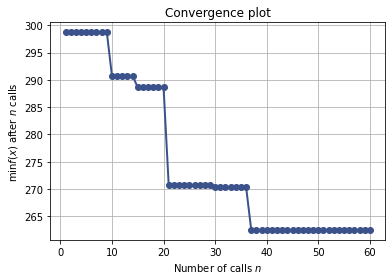

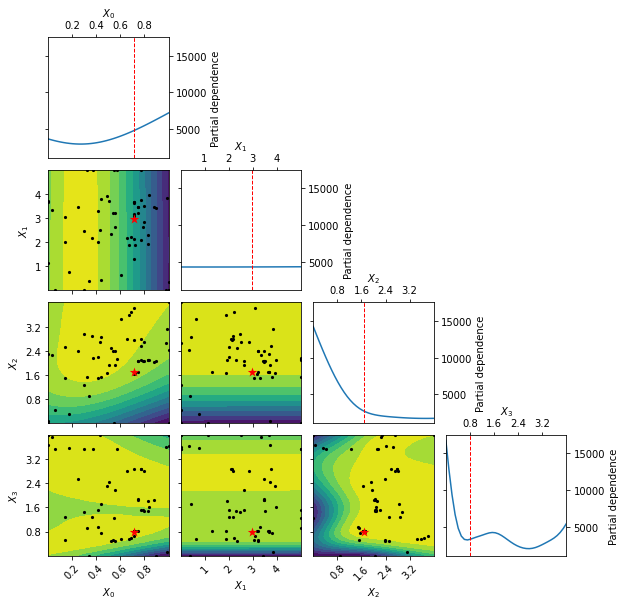

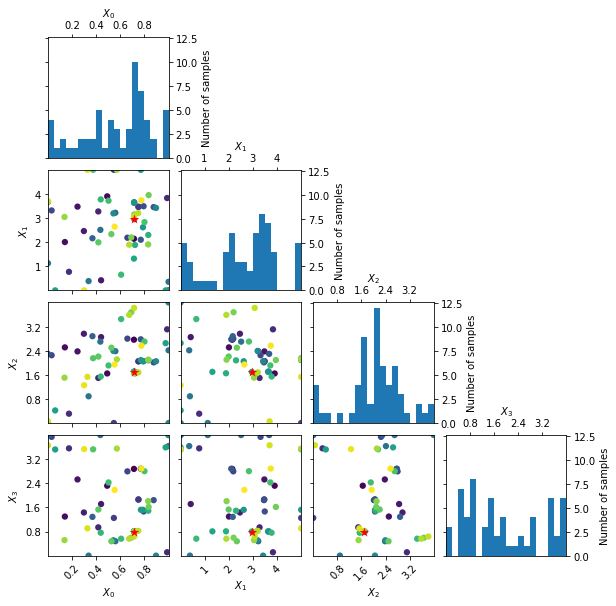

In [246]:
skplt.plot_convergence(res);
skplt.plot_objective(res);
skplt.plot_evaluations(res);

In [29]:
@njit
def simulate(params, N0s, dists, raw):
    raw_copy = raw.copy()
    distance_weights = [[1/(np.power((params[2] * dists[i][j] + 1), params[3])) for j in range(0, 25)] for i in range(0, 25)]
    for i in range(0, 46):
        for j in range(25*i, 25*(i+1)):
            psum = np.array([distance_weights[int(raw_copy[j][1])][int(raw_copy[x][1])] *
                             (raw_copy[x][2]*(np.exp((-(i-raw_copy[x][0]-1))/params[1])
                                              - np.exp(-(i-raw_copy[x][0])/params[1]))) for x in range(0, i*25)])
            raw_copy[j][4] = N0s[int(raw_copy[j][1])] + params[0] * psum.sum()
            if j != 0:
                raw_copy[j][5] = raw_copy[j-1][5] + (raw_copy[j][4] - (raw_copy[j][2] * np.log(raw_copy[j][4])))
            if np.isnan(psum.sum()):
                print(params)
    return raw_copy

In [248]:
sim_data = simulate(np.asarray([res.x[0], res.x[1], res.x[2], res.x[3]]), N, distances, raw_data)

In [249]:
sim_df = pd.DataFrame({'Event start date':sim_data[:, 0], 'Oblast':sim_data[:, 1], 'Number of events':sim_data[:, 2],
                       'Number of protesters':sim_data[:, 3], 'Simulated':sim_data[:, 4], 'loss':sim_data[:, 5]})

In [250]:
sim_df.tail()

,Event start date,Oblast,Number of events,Number of protesters,Simulated,loss
1145,45.0,20.0,3.0,0.0,1.668536,259.137959
1146,45.0,21.0,0.0,0.0,0.562160,259.700119
1147,45.0,22.0,0.0,0.0,1.216504,260.916623
1148,45.0,23.0,0.0,0.0,0.855618,261.772241
1149,45.0,24.0,0.0,0.0,0.742733,262.514974


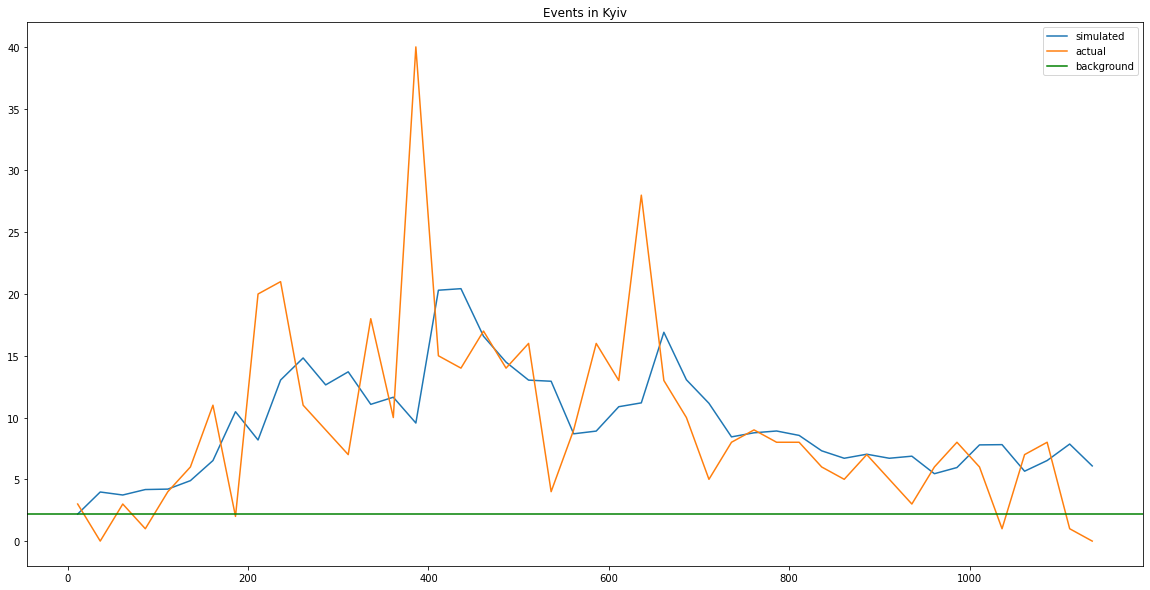

In [109]:
oblast = oblast_int['Kyiv']
plt.figure(figsize=(20,10))
plt.plot(sim_df.loc[sim_df['Oblast']==oblast]['Simulated'], label='simulated')
plt.plot(sim_df.loc[sim_df['Oblast']==oblast]['Number of events'], label='actual')
plt.axhline(y=N[oblast], color='g', label='background')
plt.title("Events in Kyiv")
plt.legend()

In [252]:
computeLoss(sim_df.loc[sim_df['Oblast']==oblast]['Simulated'], sim_df.loc[sim_df['Oblast']==oblast]['Number of events'])

-579.104721589517

In [253]:
computeLoss(sim_df['Number of events'], sim_df['Number of events'])

/Users/lucaswebb/pandas/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


-846.702061520878

In [254]:
computeLoss(sim_df['Simulated'], sim_df['Number of events'])

262.82287025146786

In [255]:
# Double check
total = 0
for i in range(0, 25):
    total += computeLoss(sim_df.loc[sim_df['Oblast']==i]['Simulated'], sim_df.loc[sim_df['Oblast']==i]['Number of events'])
print(total)

262.8228702514678


In [30]:
# Look at the null hypothesis of a non-distance dependent model
def toMinimize2(params):
    params = np.append(np.asarray(params), [0.0, 0.0])
    return toMinimizeHelper(params, N, distances, raw_data)

In [257]:
%%time
res2 = gp_minimize(toMinimize2, [(0.0, 1.0), (0.01, 10.0)], n_calls=60, noise=1e-10, n_initial_points=10, random_state=123)

CPU times: user 2min 24s, sys: 19.5 s, total: 2min 44s
Wall time: 57.4 s


In [258]:
res2.x

[0.028004306746023656, 0.8282421557705002]

In [259]:
res2.fun

434.28164951069243

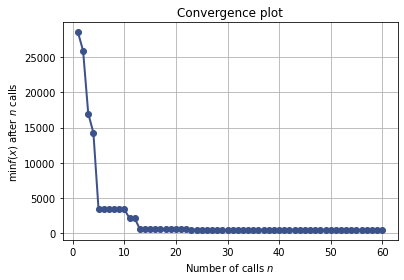

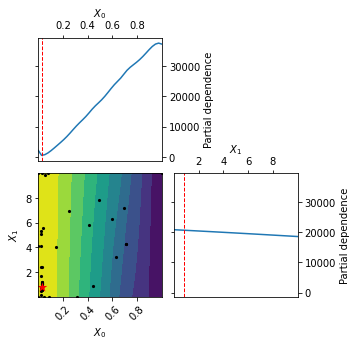

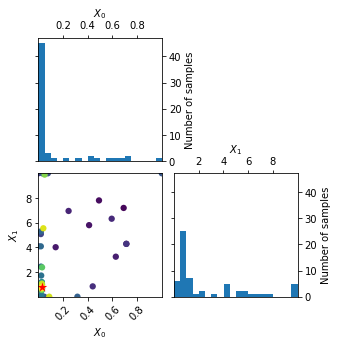

In [260]:
skplt.plot_convergence(res2);
skplt.plot_objective(res2);
skplt.plot_evaluations(res2);

In [261]:
sim_data = simulate(np.asarray([res2.x[0], res2.x[1], 0, 0]), N, distances, raw_data)

In [262]:
sim_df = pd.DataFrame({'Event start date':sim_data[:, 0], 'Oblast':sim_data[:, 1], 'Number of events':sim_data[:, 2],
                       'Number of protesters':sim_data[:, 3], 'Simulated':sim_data[:, 4], 'loss':sim_data[:, 5]})

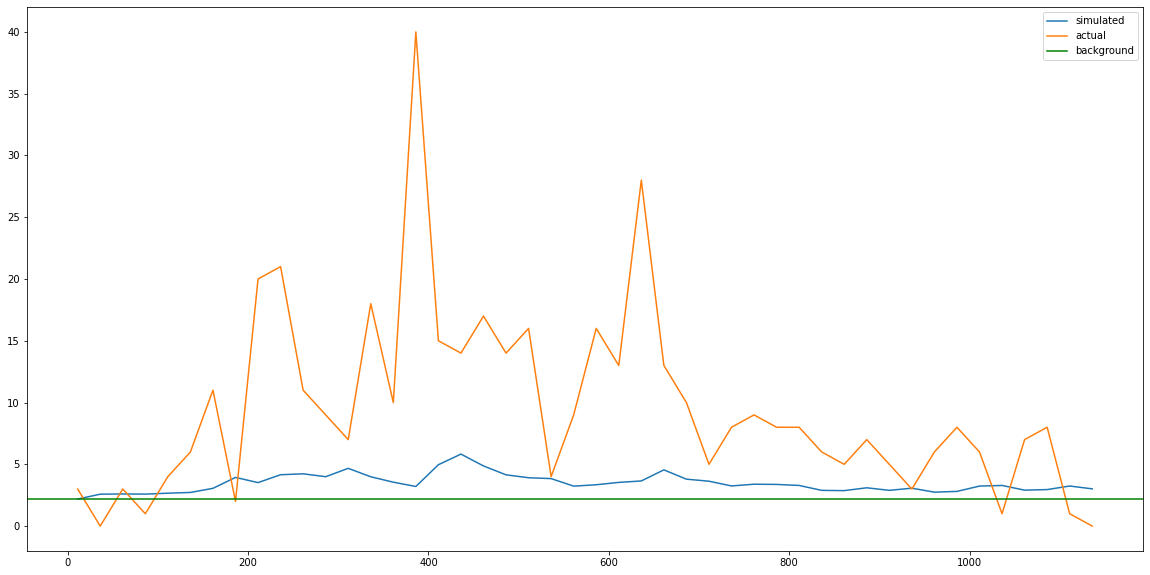

In [263]:
oblast = oblast_int['Kyiv']
plt.figure(figsize=(20,10))
plt.plot(sim_df.loc[sim_df['Oblast']==oblast]['Simulated'], label='simulated')
plt.plot(sim_df.loc[sim_df['Oblast']==oblast]['Number of events'], label='actual')
plt.axhline(y=N[oblast], color='g', label='background')
plt.legend()

In [264]:
sim_df.tail()

,Event start date,Oblast,Number of events,Number of protesters,Simulated,loss
1145,45.0,20.0,3.0,0.0,1.198273,430.340581
1146,45.0,21.0,0.0,0.0,0.908293,431.248874
1147,45.0,22.0,0.0,0.0,1.029726,432.278600
1148,45.0,23.0,0.0,0.0,0.908293,433.186893
1149,45.0,24.0,0.0,0.0,1.094756,434.281650


In [265]:
computeLoss(sim_df.loc[sim_df['Oblast']==oblast]['Simulated'], sim_df.loc[sim_df['Oblast']==oblast]['Number of events'])

-402.8510193409351

In [266]:
computeLoss(sim_df['Simulated'], sim_df['Number of events'])

# Distance dependent model beats null-hypothesis 263 to 435 after 60 iterations on each

434.58954599377114

In [85]:
# Lets make an attempt at fitting the same model but the 25 individual Nsec params
@njit
def toMinimizeHelper3(params, N0s, dists, raw):
    raw_copy = raw.copy()
    distance_weights = [[1/(np.power((params[1] * dists[i][j] + 1), params[2])) for j in range(0, 25)] for i in range(0, 25)]
    for i in range(0, 46):
        for j in range(25*i, 25*(i+1)):
            psum = np.array([distance_weights[int(raw_copy[j][1])][int(raw_copy[x][1])] *
                             (raw_copy[x][2]*(np.exp((-(i-raw_copy[x][0]-1))/params[0])
                                              - np.exp(-(i-raw_copy[x][0])/params[0]))) for x in range(0, i*25)])
            raw_copy[j][4] = N0s[int(raw_copy[j][1])] + params[3 + int(raw_copy[j][1])] * psum.sum()
            if j != 0:
                raw_copy[j][5] = raw_copy[j-1][5] + (raw_copy[j][4] - (raw_copy[j][2] * np.log(raw_copy[j][4])))
            if np.isnan(psum.sum()):
                print(i)
                print(j)
                print(params)
    return raw_copy[1149][5]

In [97]:
@njit
def simulate3(params, N0s, dists, raw):
    raw_copy = raw.copy()
    distance_weights = [[1/(np.power((params[1] * dists[i][j] + 1), params[2])) for j in range(0, 25)] for i in range(0, 25)]
    for i in range(0, 46):
        for j in range(25*i, 25*(i+1)):
            psum = np.array([distance_weights[int(raw_copy[j][1])][int(raw_copy[x][1])] *
                             (raw_copy[x][2]*(np.exp((-(i-raw_copy[x][0]-1))/params[0])
                                              - np.exp(-(i-raw_copy[x][0])/params[0]))) for x in range(0, i*25)])
            raw_copy[j][4] = N0s[int(raw_copy[j][1])] + params[3 + int(raw_copy[j][1])] * psum.sum()
            if j != 0:
                raw_copy[j][5] = raw_copy[j-1][5] + (raw_copy[j][4] - (raw_copy[j][2] * np.log(raw_copy[j][4])))
            if np.isnan(psum.sum()):
                print(i)
                print(j)
                print(params)
    return raw_copy

In [86]:
def toMinimize3(params):
    params = np.asarray(params)
    return toMinimizeHelper3(params, N, distances, raw_data)

In [109]:
%%timeit
toMinimize3([3.1258243484283104,
             3.0370464476472527,
             0.49446471666853,
             0.3735753654421955,
             0.23185011250779267,
             0.27452652132325966,
             0.33744603530408834,
             0.37611902707920536,
             0.47488181689478975,
             0.3318703424006064,
             0.3824295852682288,
             0.38724321220699476,
             0.40056103834343343,
             0.16826211343203867,
             0.42712960592260835,
             0.475428954423541,
             0.4331749309431421,
             0.18541724336599513,
             0.04022648521199316,
             0.33134550486700803,
             0.3634431971958089,
             0.06667025089352538,
             0.025777591194994044,
             0.26186108592312723,
             0.10714308290309499,
             0.19922076309189043,
             0.26524646033888166,
             0.15560390129222088])

23.6 ms ± 5.39 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [110]:
%%time
res3 = gp_minimize(toMinimize3, [(0.01, 10.0), (0.0, 4.0), (0.0, 4.0), (0.0, 0.5),(0.0, 0.5),(0.0, 0.5),(0.0, 0.5),(0.0, 0.5),(0.0, 0.5),(0.0, 0.5),(0.0, 0.5),(0.0, 0.5),(0.0, 0.5),(0.0, 0.5),(0.0, 0.5),(0.0, 0.5),(0.0, 0.5),(0.0, 0.5),(0.0, 0.5),(0.0, 0.5),(0.0, 0.5),(0.0, 0.5),(0.0, 0.5),(0.0, 0.5),(0.0, 0.5),(0.0, 0.5),(0.0, 0.5),(0.0, 0.5)],
                   n_calls=200, noise=1e-10, n_initial_points=1, n_jobs=-1, random_state=123)

CPU times: user 40min 2s, sys: 7min 4s, total: 47min 6s
Wall time: 16min 7s


In [111]:
res3.x

[2.0501620217139025,
 4.0,
 0.4753682299323879,
 0.4968650057398565,
 0.5,
 0.42570653219708904,
 0.5,
 0.4972378885749953,
 0.22012176487052848,
 0.47344201522977725,
 0.2436466993237128,
 0.30529558437071225,
 0.4975364901360639,
 0.30427555408988927,
 0.5,
 0.20218567290209397,
 0.4855607416909282,
 0.5,
 0.4983913103466903,
 0.5,
 0.4658004290374165,
 0.5,
 0.3064337903578348,
 0.5,
 0.5,
 0.4355624261341308,
 0.3351625766656573,
 0.33833697280443875]

In [112]:
res3.fun

253.66865548248848

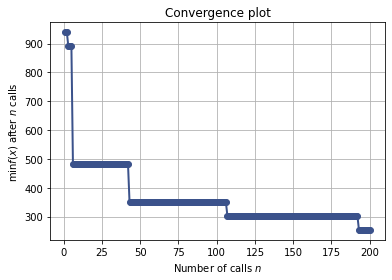

In [113]:
skplt.plot_convergence(res3);

In [114]:
from skopt import dump, load

In [115]:
dump(res3, 'result_200_iter.pkl')

In [61]:
from skopt import Optimizer
from joblib import Parallel, delayed

In [8]:
res_loaded = load('result_200_iter.pkl')
x0 = res_loaded.x_iters
y0 = list(res_loaded.func_vals)

In [100]:
opt = Optimizer(
    dimensions=[(0.01, 10.0), (0.0, 4.0), (0.0, 4.0), (0.0, 0.5),(0.0, 0.5),(0.0, 0.5),(0.0, 0.5),(0.0, 0.5),(0.0, 0.5),(0.0, 0.5),(0.0, 0.5),(0.0, 0.5),(0.0, 0.5),(0.0, 0.5),(0.0, 0.5),(0.0, 0.5),(0.0, 0.5),(0.0, 0.5),(0.0, 0.5),(0.0, 0.5),(0.0, 0.5),(0.0, 0.5),(0.0, 0.5),(0.0, 0.5),(0.0, 0.5),(0.0, 0.5),(0.0, 0.5),(0.0, 0.5)],
    random_state=123,
    base_estimator='gp',
    n_initial_points=1
)

In [17]:
opt.tell(x0, y0);

In [101]:
%%time
for i in range(10):
    x = opt.ask(n_points=4)  # x is a list of n_points points
    y = Parallel(n_jobs=4)(delayed(toMinimize3)(v) for v in x)  # evaluate points in parallel
    opt.tell(x, y)

CPU times: user 3min 14s, sys: 25.6 s, total: 3min 40s
Wall time: 1min 26s


In [104]:
min(opt.yi)


701.2796041631033

In [38]:
from scipy.optimize import fmin_l_bfgs_b

In [80]:
res5 = fmin_l_bfgs_b(toMinimize3,
                     [ 1.0282752 , 20.51287915,  0.16880172,  0.13243282,  0.06330424,
                       0.09109119,  0.06852974,  0.07307468,  0.0810518 ,  0.14960758,
                       0.06924349,  0.0627621 ,  0.07734331,  0.07542613,  0.4177983 ,
                       0.1263188 ,  0.14790044,  0.19316342,  0.10031524,  0.13221806,
                       0.08912528,  0.13193445,  0.05755433,  0.1516172 ,  0.17245183,
                       0.0637139 ,  0.10774846,  0.0579212 ],
              approx_grad=True,
              bounds=[(0.001, 10), (0.0, 100.0), (0.0, 10.0), (0.0, 1.0),(0.0, 1.0),(0.0, 1.0),(0.0, 1.0),(0.0, 1.0),(0.0, 1.0),(0.0, 1.0),(0.0, 1.0),(0.0, 1.0),(0.0, 1.0),(0.0, 1.0),(0.0, 1.0),(0.0, 1.0),(0.0, 1.0),(0.0, 1.0),(0.0, 1.0),(0.0, 1.0),(0.0, 1.0),(0.0, 1.0),(0.0, 1.0),(0.0, 1.0),(0.0, 1.0),(0.0, 1.0),(0.0, 1.0),(0.0, 1.0)],
              epsilon=1e-08,
              maxfun=4000)

In [81]:
res5[1]

170.62419946669155

In [82]:
res5

(array([ 1.03167466, 20.5128954 ,  0.16905126,  0.1326973 ,  0.06342644,
         0.09125231,  0.06869486,  0.07321769,  0.08122357,  0.149832  ,
         0.06939482,  0.06289796,  0.07747242,  0.07556337,  0.41809267,
         0.12656806,  0.14811481,  0.19347961,  0.10048872,  0.13244636,
         0.08929258,  0.13217459,  0.05768662,  0.15184296,  0.17279593,
         0.06383375,  0.1079563 ,  0.05803216]),
 170.62419946669155,
 {'grad': array([-1.21360700e-03, -3.41060485e-04,  1.71837655e-02,  8.75388651e-04,
          3.04112291e-04,  4.43378667e-03,  6.99174052e-04,  2.52953214e-04,
          1.13686838e-04, -3.60955710e-04,  4.51905180e-04,  6.34656772e-03,
         -2.65458766e-03,  2.31636932e-03,  3.28270744e-03,  1.98951966e-04,
         -6.53699317e-04,  7.95807864e-05, -7.67386155e-05,  1.33582034e-04,
          2.55795385e-05,  9.66338121e-05,  2.84217094e-04, -4.57589522e-04,
          3.21165317e-04, -1.35059963e-02, -3.72324394e-04, -7.07416348e-03]),
  'task': 'CONVE

In [91]:
def toMinimize31(params):
    params = np.insert(np.asarray(params), 1, [0, 0])
    return toMinimizeHelper3(params, N, distances, raw_data)

In [94]:
# distance null hypothesis with 25 Nsec
res51 = fmin_l_bfgs_b(toMinimize31,
                      [1.16446355, 0.03497285, 0.01517706, 0.02204523, 0.01564063,
                       0.01743337, 0.01862587, 0.0385814 , 0.01674298, 0.01479528,
                       0.01904643, 0.0183514 , 0.16100114, 0.02905405, 0.0379116 ,
                       0.05263438, 0.02497275, 0.03419347, 0.02163831, 0.03342023,
                       0.01306297, 0.03953913, 0.04202838, 0.01570377, 0.02580478,
                       0.01422764],
                     approx_grad=True,
                     bounds=[(0.001, 10), (0.0, 1.0),(0.0, 1.0),(0.0, 1.0),(0.0, 1.0),(0.0, 1.0),(0.0, 1.0),(0.0, 1.0),(0.0, 1.0),(0.0, 1.0),(0.0, 1.0),(0.0, 1.0),(0.0, 1.0),(0.0, 1.0),(0.0, 1.0),(0.0, 1.0),(0.0, 1.0),(0.0, 1.0),(0.0, 1.0),(0.0, 1.0),(0.0, 1.0),(0.0, 1.0),(0.0, 1.0),(0.0, 1.0),(0.0, 1.0),(0.0, 1.0)],
                     epsilon=1e-08,
                     maxfun=4000)

In [102]:
sim_data = simulate3(res5[0], N, distances, raw_data)

In [103]:
sim_df = pd.DataFrame({'Event start date':sim_data[:, 0], 'Oblast':sim_data[:, 1], 'Number of events':sim_data[:, 2],
                       'Number of protesters':sim_data[:, 3], 'Simulated':sim_data[:, 4], 'loss':sim_data[:, 5]})

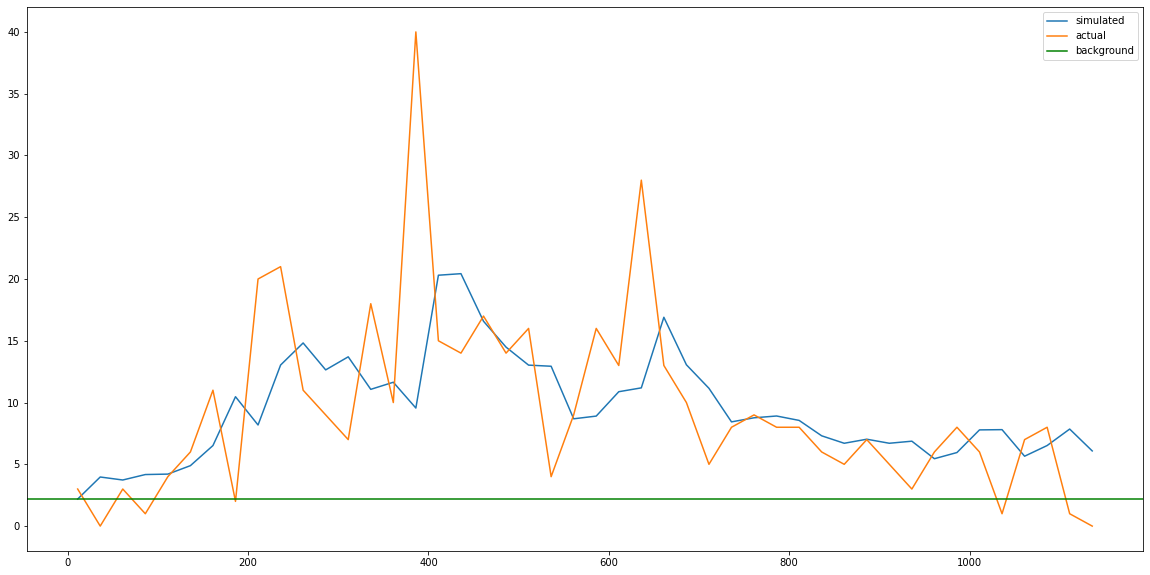

In [104]:
oblast = oblast_int['Kyiv']
plt.figure(figsize=(20,10))
plt.plot(sim_df.loc[sim_df['Oblast']==oblast]['Simulated'], label='simulated')
plt.plot(sim_df.loc[sim_df['Oblast']==oblast]['Number of events'], label='actual')
plt.axhline(y=N[oblast], color='g', label='background')
plt.legend()

In [105]:
computeLoss(sim_df.loc[sim_df['Oblast']==oblast]['Simulated'], sim_df.loc[sim_df['Oblast']==oblast]['Number of events'])


-578.6014761210045

In [96]:
res51

# With distance: 170.6, w/ out: 176.3

(array([1.16446355, 0.03497284, 0.01517705, 0.02204516, 0.01564061,
        0.01743333, 0.01862583, 0.0385814 , 0.01674298, 0.01479535,
        0.01904626, 0.01835154, 0.1610011 , 0.02905399, 0.03791159,
        0.05263433, 0.02497275, 0.03419347, 0.02163827, 0.03342021,
        0.01306282, 0.03953913, 0.04202836, 0.01570384, 0.02580474,
        0.01422762]),
 176.33178461405092,
 {'grad': array([-1.53477232e-04,  4.29167812e-04, -1.76214598e-04,  3.55271368e-04,
          2.52953214e-04,  9.94759830e-05,  8.18545231e-04,  4.26325641e-05,
         -1.39266376e-04,  1.05728759e-03, -1.61719527e-03,  2.57784904e-03,
          3.27986527e-03,  1.59161573e-03,  2.24531504e-04,  2.73416845e-03,
         -4.26325641e-05, -2.16004992e-04,  4.17799129e-04,  5.17275112e-04,
          2.56079602e-03,  1.62003744e-04,  6.65068001e-04,  1.17950094e-03,
          4.57589522e-04, -3.49587026e-04]),
  'task': 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH',
  'funcalls': 108,
  'nit': 1,
  'warnfla

In [137]:
# Apply scipy optimize to previous trials

res6 = fmin_l_bfgs_b(toMinimize,
                     [0.3, 3, 2, 2],
                     approx_grad=True,
                     bounds=[(0.0, 2.0), (0.0001, 10.0), (0.0, 10.0), (0.0, 10.0)],
                     epsilon=1e-08,
                     maxfun=4000)

In [138]:
res6

(array([0.54452377, 2.05991912, 1.76684235, 0.62133614]),
 247.79224197365417,
 {'grad': array([-0.0204551 ,  0.00027285, -0.02227694,  0.03390994]),
  'task': 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH',
  'funcalls': 170,
  'nit': 26,
  'warnflag': 0})

In [147]:
# Null hypothesis
res7 = fmin_l_bfgs_b(toMinimize2,
                     [0.03, 0.8],
                     approx_grad=True,
                     bounds=[(0.0, 2.0), (0.00001, 10.0)],
                     epsilon=1e-08,
                     maxfun=4000)

In [148]:
res7

(array([0.02798585, 0.82226722]),
 434.2810988147224,
 {'grad': array([-1.14255272e-03,  4.54747349e-05]),
  'task': 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH',
  'funcalls': 30,
  'nit': 7,
  'warnflag': 0})

In [41]:
# Try adding a parameter to scale by # of protesters
@njit
def toMinimizeHelper4(params, N0s, dists, raw):
    raw_copy = raw.copy()
    distance_weights = [[1/(np.power((params[2] * dists[i][j] + 1), params[3])) for j in range(0, 25)] for i in range(0, 25)]
    for i in range(0, 46):
        for j in range(25*i, 25*(i+1)):
            psum = np.array([distance_weights[int(raw_copy[j][1])][int(raw_copy[x][1])] *
                              np.log(params[4] * raw_copy[x][3]+1) *
                             (raw_copy[x][2]*(np.exp((-(i-raw_copy[x][0]-1))/params[1])
                                              - np.exp(-(i-raw_copy[x][0])/params[1]))) for x in range(0, i*25)])
            raw_copy[j][4] = N0s[int(raw_copy[j][1])] + params[0] * psum.sum()
            if j != 0:
                raw_copy[j][5] = raw_copy[j-1][5] + (raw_copy[j][4] - (raw_copy[j][2] * np.log(raw_copy[j][4])))
            # if np.isnan(psum.sum()):
            #     print(i)
            #     print(j)
            #     print(params)
    # print(raw_copy[1149][5])
    return raw_copy[1149][5]

In [42]:
def toMinimize4(params):
    params = np.asarray(params)
    return toMinimizeHelper4(params, N, distances, raw_data)


In [67]:
res8 = fmin_l_bfgs_b(toMinimize4,
                     [0.3, 0.8, 1.0, 1.0, 1.0],
                     approx_grad=True,
                     bounds=[(0.0, 2.0), (0.0001, 10.0), (0.0, 10000.0), (0.0, 10.0), (0.0, 10000.0)],
                     epsilon=1e-08,
                     maxfun=4000)

In [68]:
res8

(array([4.44780835e-02, 2.00402165e+00, 1.82930373e+03, 2.52157121e-01,
        1.00601317e+02]),
 249.4729109869205,
 {'grad': array([6.03392891e-03, 5.13580293e-03, 1.13688040e-05, 1.70331305e-02,
         2.55795545e-05]),
  'task': 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH',
  'funcalls': 1734,
  'nit': 202,
  'warnflag': 0})

In [73]:
%%time
res9 = gp_minimize(toMinimize4, [(0.0, 0.5), (0.0001, 10.0), (0.0, 2000.0), (0.0, 20.0), (0.0, 1000.0)],
                   n_calls=160, noise=1e-10, n_initial_points=10, n_jobs=-1, random_state=123)

CPU times: user 10min 37s, sys: 1min 37s, total: 12min 14s
Wall time: 4min 32s


In [74]:
res9.x

[0.04841737101286381,
 3.7109864451113466,
 84.47226098736226,
 0.4813219661450502,
 969.3242417292399]

In [108]:
res9.fun

318.82241348660733

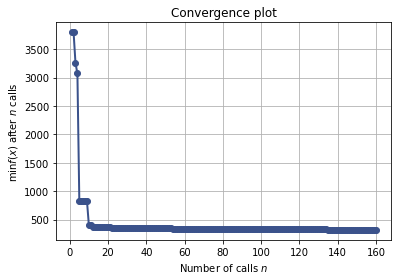

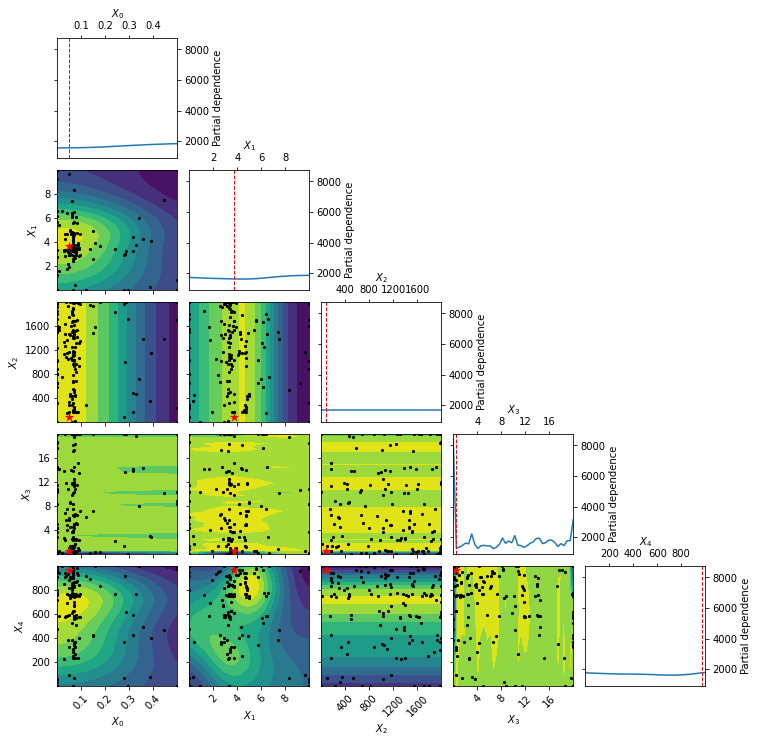

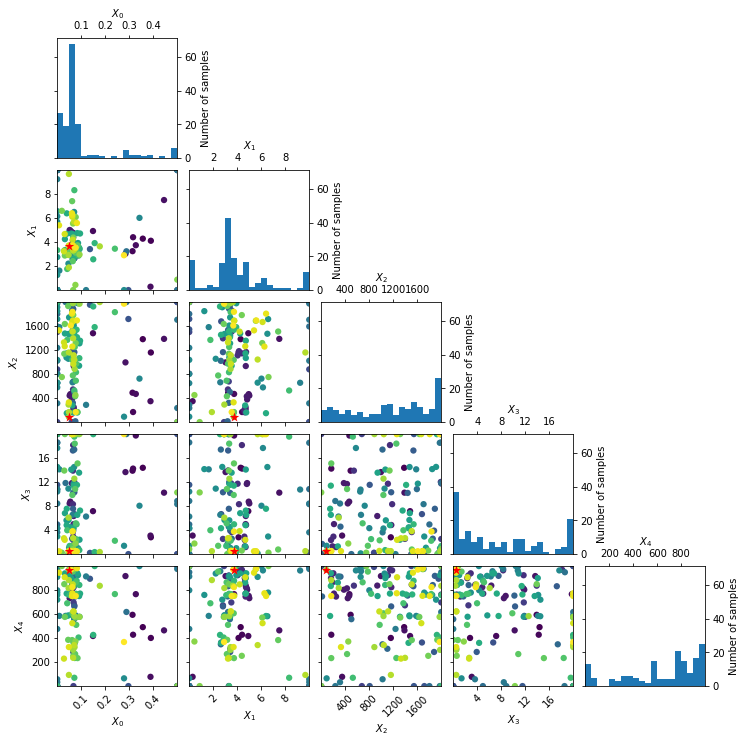

In [76]:
skplt.plot_convergence(res9);
skplt.plot_objective(res9);
skplt.plot_evaluations(res9);

In [62]:
opt = Optimizer(
    dimensions=[(0.0, 0.5), (0.0001, 10.0), (0.0, 4.0), (0.0, 20.0), (0.0, 10.0)],
    random_state=123,
    base_estimator='gp',
    n_initial_points=10
)

In [63]:
%%time
for i in range(20):
    x = opt.ask(n_points=4)  # x is a list of n_points points
    y = Parallel(n_jobs=4)(delayed(toMinimize4)(v) for v in x)  # evaluate points in parallel
    opt.tell(x, y)

CPU times: user 5min 11s, sys: 40.6 s, total: 5min 52s
Wall time: 2min 3s


In [64]:
min(opt.yi)


395.41829667450486

In [ ]:
# need to try adding a scaling param to an average background
# and then see if distance beats null-hypothesis